# [How to do Transfer learning with Efficientnet](https://www.dlology.com/blog/transfer-learning-with-efficientnet/) | DLology

## Imports

In [2]:
# # Downgrade pillow to avoid `UserWarning: Possibly corrupt EXIF data.`
# !pip install pillow==4.0.0

In [3]:
# import os
# os.path.abspath('/home/yupaporn/miniconda3/envs/effnet/lib/python3.5/')
# !ls
# import numpy as np

In [1]:
from tensorflow.keras import models
from tensorflow.keras import layers
from tensorflow.keras import optimizers
import os
import glob
import shutil
import sys
import numpy as np
from skimage.io import imread
import matplotlib.pyplot as plt
from IPython.display import Image
%matplotlib inline

## Hyper parameters
### การตั้งค่าพารามิเตอร์ต่างๆ

In [2]:
#only have 2 label
batch_size = 48 #จำนวน data ที่ส่งไป Train ในแต่ละครั้ง จนครบจำนวนเต็ม x_train

width = 150 
height = 150 
input_shape = (height, width, 3) #ขนาด image enter

epochs = 20  #จำนวนรอบในการ Train
NUM_TRAIN = 2000 # จำนวนภาพ Train
NUM_TEST = 1000 #จำนวนภาพ Test
dropout_rate = 0.2 #คือการปิดบาง Node หรือเรียกว่าทำการ Drop Out ไป ซึ่งขึ้นกับการตั้งค่าว่าจะให้ลืมไปกี่เปอร์เซนต์ดี ช่วยในการแก้ปัญหา Overfitting


## Clone **efficientnet** repo

In [3]:
import os
os.path.abspath('/home/yupaporn/EfficientNet_USAI/')
!ls

content					    README.md	     Untitled.ipynb
Keras_efficientnet_transfer_learning.ipynb  Untitled1.ipynb
myenv					    Untitled2.ipynb


In [4]:
#สร้างโฟล์เดอร์ content ก่อน 

import os
%cd content
if not os.path.isdir("efficientnet_keras_transfer_learning"):
  !git clone https://github.com/Tony607/efficientnet_keras_transfer_learning
%cd efficientnet_keras_transfer_learning/

# %cd content/efficientnet_keras_transfer_learning/

/home/yupaporn/EfficientNet_USAI/content
/home/yupaporn/EfficientNet_USAI/content/efficientnet_keras_transfer_learning


## Import efficientnet and load the conv base model

In [5]:
# Options: EfficientNetB0, EfficientNetB1, EfficientNetB2, EfficientNetB3
# Higher the number, the more complex the model is.

from efficientnet import EfficientNetB0 as Net
from efficientnet import center_crop_and_resize, preprocess_input

Using TensorFlow backend.


In [6]:
# loading pretrained conv base model

conv_base = Net(weights='imagenet', include_top=False, input_shape=input_shape)
#ซึ่งหมายความว่าเลเยอร์สุดท้ายสำหรับการจำแนกไม่เป็นประโยชน์ เพราะทีทำมีเเค่ 2 label include_top=False 

## Download and extract `dog_vs_cat` dataset

In [9]:
if not os.path.isfile("kagglecatsanddogs_3367a.zip"):
  !wget https://download.microsoft.com/download/3/E/1/3E1C3F21-ECDB-4869-8368-6DEBA77B919F/kagglecatsanddogs_3367a.zip
  !unzip -qq kagglecatsanddogs_3367a.zip -d dog_vs_cat
else:
  print("dataset already exist.")

--2020-05-13 15:00:12--  https://download.microsoft.com/download/3/E/1/3E1C3F21-ECDB-4869-8368-6DEBA77B919F/kagglecatsanddogs_3367a.zip
Resolving download.microsoft.com (download.microsoft.com)... 23.208.171.22, 2600:140b:4:7b6::e59, 2600:140b:4:78c::e59
Connecting to download.microsoft.com (download.microsoft.com)|23.208.171.22|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 824894548 (787M) [application/octet-stream]
Saving to: ‘kagglecatsanddogs_3367a.zip’

kagglecatsanddogs_3 100%[===================>] 786.68M  90.7MB/s    in 12s     

2020-05-13 15:00:24 (67.4 MB/s) - ‘kagglecatsanddogs_3367a.zip’ saved [824894548/824894548]



In [7]:
!ls dog_vs_cat/PetImages/
!ls dog_vs_cat/PetImages/Cat -l -t | head -10

Cat  Dog
total 408428
-rw-rw-r-- 1 yupaporn yupaporn   34297 Feb 10  2017 9955.jpg
-rw-rw-r-- 1 yupaporn yupaporn   26013 Feb 10  2017 9956.jpg
-rw-rw-r-- 1 yupaporn yupaporn   26293 Feb 10  2017 9957.jpg
-rw-rw-r-- 1 yupaporn yupaporn   36293 Feb 10  2017 9958.jpg
-rw-rw-r-- 1 yupaporn yupaporn   36690 Feb 10  2017 9959.jpg
-rw-rw-r-- 1 yupaporn yupaporn   15262 Feb 10  2017 9960.jpg
-rw-rw-r-- 1 yupaporn yupaporn   49493 Feb 10  2017 9961.jpg
-rw-rw-r-- 1 yupaporn yupaporn   14785 Feb 10  2017 9962.jpg
-rw-rw-r-- 1 yupaporn yupaporn   39717 Feb 10  2017 9963.jpg
ls: write error: Broken pipe


In [8]:
# The path to the directory where the original
# dataset was uncompressed
original_dataset_dir = './dog_vs_cat/PetImages'

cat_images = glob.glob(os.path.join(original_dataset_dir, "Cat", '*.jpg'))
dog_images = glob.glob(os.path.join(original_dataset_dir, "Dog", '*.jpg'))
print("total cat images: {}\n\rtotal dog images: {}".format(len(cat_images), len(dog_images)))

total cat images: 12500
total dog images: 12498


In [9]:
# การเเบ่ดข้อมูล  train/validation/test sets

# The directory where we will
# store our smaller dataset
base_dir = './data/dog_vs_cat_small'
os.makedirs(base_dir, exist_ok=True)

# Directories for our training,
# validation and test splits
train_dir = os.path.join(base_dir, 'train')
os.makedirs(train_dir, exist_ok=True)
validation_dir = os.path.join(base_dir, 'validation')
os.makedirs(validation_dir, exist_ok=True)
test_dir = os.path.join(base_dir, 'test')
os.makedirs(test_dir, exist_ok=True)

# Directory with our training cat pictures
train_cats_dir = os.path.join(train_dir, 'cats')
os.makedirs(train_cats_dir, exist_ok=True)

# Directory with our training dog pictures
train_dogs_dir = os.path.join(train_dir, 'dogs')
os.makedirs(train_dogs_dir, exist_ok=True)

# Directory with our validation cat pictures
validation_cats_dir = os.path.join(validation_dir, 'cats')
os.makedirs(validation_cats_dir, exist_ok=True)

# Directory with our validation dog pictures
validation_dogs_dir = os.path.join(validation_dir, 'dogs')
os.makedirs(validation_dogs_dir, exist_ok=True)

# Directory with our validation cat pictures
test_cats_dir = os.path.join(test_dir, 'cats')
os.makedirs(test_cats_dir, exist_ok=True)

# Directory with our validation dog pictures
test_dogs_dir = os.path.join(test_dir, 'dogs')
os.makedirs(test_dogs_dir, exist_ok=True)

# Copy first NUM_TRAIN//2 cat images to train_cats_dir
fnames = cat_images[:NUM_TRAIN//2]
for fname in fnames:
    dst = os.path.join(train_cats_dir, os.path.basename(fname))
    shutil.copyfile(fname, dst)

offset = NUM_TRAIN//2
# Copy next NUM_TEST //2 cat images to validation_cats_dir
fnames = cat_images[offset:offset + NUM_TEST // 2]
for fname in fnames:
    dst = os.path.join(validation_cats_dir, os.path.basename(fname))
    shutil.copyfile(fname, dst)
offset = offset + NUM_TEST // 2
# Copy next NUM_TRAIN//2 cat images to test_cats_dir
fnames = cat_images[offset:offset + NUM_TEST // 2]
for fname in fnames:
    dst = os.path.join(test_cats_dir, os.path.basename(fname))
    shutil.copyfile(fname, dst)


# Copy first NUM_TRAIN//2 dog images to train_dogs_dir
fnames = dog_images[:NUM_TRAIN//2]
for fname in fnames:
    dst = os.path.join(train_dogs_dir, os.path.basename(fname))
    shutil.copyfile(fname, dst)

offset = NUM_TRAIN//2
# Copy next NUM_TEST // 2 dog images to validation_dogs_dir
fnames = dog_images[offset:offset + NUM_TEST // 2]
for fname in fnames:
    dst = os.path.join(validation_dogs_dir, os.path.basename(fname))
    shutil.copyfile(fname, dst)
offset = offset + NUM_TEST // 2

# Copy next NUM_TEST // 2 dog images to test_dogs_dir
fnames = dog_images[offset:offset + NUM_TEST // 2]
for fname in fnames:
    dst = os.path.join(test_dogs_dir, os.path.basename(fname))
    shutil.copyfile(fname, dst)

In [10]:
print('total training cat images:', len(os.listdir(train_cats_dir)))
print('total training dog images:', len(os.listdir(train_dogs_dir)))
print('total validation cat images:', len(os.listdir(validation_cats_dir)))
print('total validation dog images:', len(os.listdir(validation_dogs_dir)))
print('total test cat images:', len(os.listdir(test_cats_dir)))
print('total test dog images:', len(os.listdir(test_dogs_dir)))

total training cat images: 1000
total training dog images: 1000
total validation cat images: 500
total validation dog images: 500
total test cat images: 500
total test dog images: 500


In [11]:
# data augmentation เพื่อลดโอกาสการเกิด overfitting

from tensorflow.keras.preprocessing.image import ImageDataGenerator

train_datagen = ImageDataGenerator(
      rescale=1./255, #ย่อ image
      rotation_range=40, # หมุนภาพในช่วงที่สุ่ม
      width_shift_range=0.2, #เปลี่ยนความกว้าง
      height_shift_range=0.2, #ปลี่ยนความสูง
      shear_range=0.2, #ตัด,เฉือน
      zoom_range=0.2, #ซุม image
      horizontal_flip=True, #พลิกภาพแบบสุ่มตามแนวนอน
      fill_mode='nearest') 

# Note that the validation data should not be augmented!
test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
        # This is the target directory
        train_dir,
        # All images will be resized to target height and width.
        target_size=(height, width),
        batch_size=batch_size,
        # Since we use categorical_crossentropy loss, we need categorical labels
        class_mode='categorical')

validation_generator = test_datagen.flow_from_directory(
        validation_dir,
        target_size=(height, width),
        batch_size=batch_size,
        class_mode='categorical')

Found 2000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.


In [12]:
model = models.Sequential()
model.add(conv_base)
model.add(layers.GlobalMaxPooling2D(name="gap"))
# model.add(layers.Flatten(name="flatten"))
if dropout_rate > 0:
    model.add(layers.Dropout(dropout_rate, name="dropout_out"))
# model.add(layers.Dense(256, activation='relu', name="fc1"))
model.add(layers.Dense(2, activation='softmax', name="fc_out"))

In [13]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
efficientnet-b0 (Model)      (None, 5, 5, 1280)        4049564   
_________________________________________________________________
gap (GlobalMaxPooling2D)     (None, 1280)              0         
_________________________________________________________________
dropout_out (Dropout)        (None, 1280)              0         
_________________________________________________________________
fc_out (Dense)               (None, 2)                 2562      
Total params: 4,052,126
Trainable params: 4,010,110
Non-trainable params: 42,016
_________________________________________________________________


In [14]:
print('This is the number of trainable layers '
      'before freezing the conv base:', len(model.trainable_weights))

conv_base.trainable = False  # freeze เพื่อรักษา convolutional base's weight

print('This is the number of trainable layers '
      'after freezing the conv base:', len(model.trainable_weights))

This is the number of trainable layers before freezing the conv base: 213
This is the number of trainable layers after freezing the conv base: 2


In [15]:
model.compile(loss='categorical_crossentropy',
              optimizer=optimizers.RMSprop(lr=2e-5),
              metrics=['acc'])

#history คือตัวแปรที่จะทำการเก็บประวัติการ Train Model ของเรา

history = model.fit_generator(
      train_generator,
      steps_per_epoch= NUM_TRAIN //batch_size,
      epochs=epochs,
      validation_data=validation_generator, #validation_data=(x_valid, y_valid): ใส่ data ที่เราแยกไว้เพื่อดูผล Model ว่าเกิด Overfitting เริ่มที่จุดใด
      validation_steps= NUM_TEST //batch_size,
      verbose=1,
      use_multiprocessing=True,
      workers=4)

Instructions for updating:
Please use Model.fit, which supports generators.
Epoch 1/20
41/41 [==============================] - 4s 91ms/step - loss: 2.5461 - acc: 0.3822 - val_loss: 3.1084 - val_acc: 0.3125
Epoch 2/20
41/41 [==============================] - 3s 80ms/step - loss: 2.2827 - acc: 0.4385 - val_loss: 2.8271 - val_acc: 0.3490
Epoch 3/20
41/41 [==============================] - 3s 80ms/step - loss: 2.0773 - acc: 0.4631 - val_loss: 2.5684 - val_acc: 0.3760
Epoch 4/20
41/41 [==============================] - 3s 78ms/step - loss: 1.9863 - acc: 0.4534 - val_loss: 2.3342 - val_acc: 0.4156
Epoch 5/20
41/41 [==============================] - 3s 80ms/step - loss: 1.8470 - acc: 0.4744 - val_loss: 2.0654 - val_acc: 0.4427
Epoch 6/20
41/41 [==============================] - 3s 79ms/step - loss: 1.7825 - acc: 0.4846 - val_loss: 1.8417 - val_acc: 0.4781
Epoch 7/20
41/41 [==============================] - 3s 80ms/step - loss: 1.5466 - acc: 0.5282 - val_loss: 1.6678 - val_acc: 0.5177
Epoch 8

41/41 [==============================] - 3s 79ms/step - loss: 1.0677 - acc: 0.6255 - val_loss: 0.8057 - val_acc: 0.7146
Epoch 16/20
41/41 [==============================] - 3s 79ms/step - loss: 1.0949 - acc: 0.6342 - val_loss: 0.7649 - val_acc: 0.7302
Epoch 17/20
41/41 [==============================] - 3s 79ms/step - loss: 1.0699 - acc: 0.6481 - val_loss: 0.7028 - val_acc: 0.7490
Epoch 18/20
41/41 [==============================] - 3s 79ms/step - loss: 0.9837 - acc: 0.6614 - val_loss: 0.6709 - val_acc: 0.7563
Epoch 19/20
41/41 [==============================] - 3s 77ms/step - loss: 0.9854 - acc: 0.6573 - val_loss: 0.6517 - val_acc: 0.7698
Epoch 20/20
41/41 [==============================] - 3s 76ms/step - loss: 0.9451 - acc: 0.6711 - val_loss: 0.5869 - val_acc: 0.7885


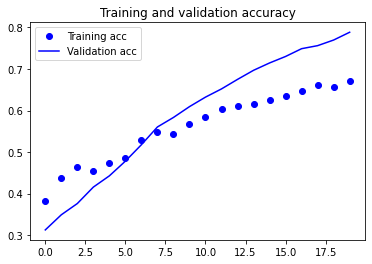

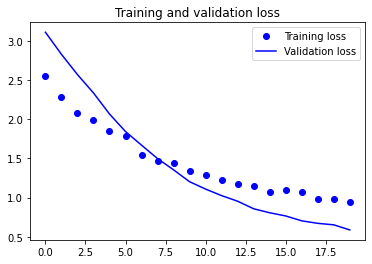

In [16]:
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_x = range(len(acc))

plt.plot(epochs_x, acc, 'bo', label='Training acc')
plt.plot(epochs_x, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs_x, loss, 'bo', label='Training loss')
plt.plot(epochs_x, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

# Fine tuning last several layers.

### The steps for fine-tuning a network are as follow:

1) Add your custom network on top of an already trained base network.

2) Freeze the base network.

3) Train the part you added.

4) Unfreeze some layers in the base network.

5) Jointly train both these layers and the part you added.

ทำไปแล้ว 3 ขั้นตอนเพื่อที่จะหาว่า layers ใดควรที่จะ unfreeze

In [17]:
# multiply_16
# set 'multiply_16' and following layers trainable (เพื่อตั้งค่า multiply_16 )

conv_base.trainable = True

set_trainable = False
for layer in conv_base.layers:
    if layer.name == 'multiply_16':
        set_trainable = True
    if set_trainable:
        layer.trainable = True
    else:
        layer.trainable = False

In [18]:
model.compile(loss='categorical_crossentropy',
              optimizer=optimizers.RMSprop(lr=2e-5),
              metrics=['acc'])

history = model.fit_generator(
      train_generator,
      steps_per_epoch= NUM_TRAIN //batch_size,
      epochs=epochs,
      validation_data=validation_generator,
      validation_steps= NUM_TEST //batch_size,
      verbose=1,
      use_multiprocessing=True,
      workers=4)

Epoch 1/20
41/41 [==============================] - 4s 94ms/step - loss: 0.9321 - acc: 0.6829 - val_loss: 0.5810 - val_acc: 0.7927
Epoch 2/20
41/41 [==============================] - 3s 78ms/step - loss: 0.9059 - acc: 0.6875 - val_loss: 0.5588 - val_acc: 0.7979
Epoch 3/20
41/41 [==============================] - 3s 78ms/step - loss: 0.8418 - acc: 0.7141 - val_loss: 0.5382 - val_acc: 0.7979
Epoch 4/20
41/41 [==============================] - 3s 80ms/step - loss: 0.8683 - acc: 0.7034 - val_loss: 0.5188 - val_acc: 0.8062
Epoch 5/20
41/41 [==============================] - 3s 80ms/step - loss: 0.8024 - acc: 0.7049 - val_loss: 0.5084 - val_acc: 0.8073
Epoch 6/20
41/41 [==============================] - 3s 79ms/step - loss: 0.8006 - acc: 0.7295 - val_loss: 0.4747 - val_acc: 0.8167
Epoch 7/20
41/41 [==============================] - 3s 80ms/step - loss: 0.8062 - acc: 0.7111 - val_loss: 0.4728 - val_acc: 0.8240
Epoch 8/20
41/41 [==============================] - 3s 81ms/step - loss: 0.8702 - a

41/41 [==============================] - 3s 83ms/step - loss: 0.7156 - acc: 0.7316 - val_loss: 0.4020 - val_acc: 0.8396
Epoch 17/20
41/41 [==============================] - 3s 79ms/step - loss: 0.6457 - acc: 0.7500 - val_loss: 0.3876 - val_acc: 0.8417
Epoch 18/20
41/41 [==============================] - 3s 79ms/step - loss: 0.7254 - acc: 0.7449 - val_loss: 0.3840 - val_acc: 0.8458
Epoch 19/20
41/41 [==============================] - 3s 80ms/step - loss: 0.7537 - acc: 0.7223 - val_loss: 0.3784 - val_acc: 0.8500
Epoch 20/20
41/41 [==============================] - 3s 82ms/step - loss: 0.7000 - acc: 0.7541 - val_loss: 0.3540 - val_acc: 0.8562


In [19]:
os.makedirs("./models", exist_ok=True)
model.save('./models/cats_and_dogs_small.h5')

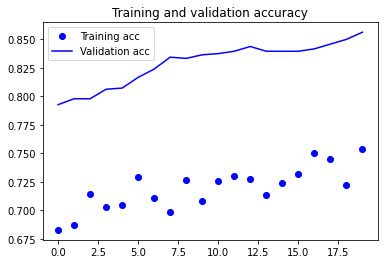

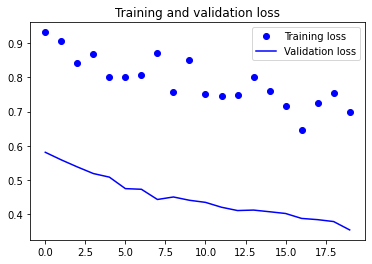

In [20]:
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_x = range(len(acc))

plt.plot(epochs_x, acc, 'bo', label='Training acc')
plt.plot(epochs_x, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs_x, loss, 'bo', label='Training loss')
plt.plot(epochs_x, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

## Test predict

In [21]:
cat_img = cat_images[-1]
dog_img= dog_images[-1]

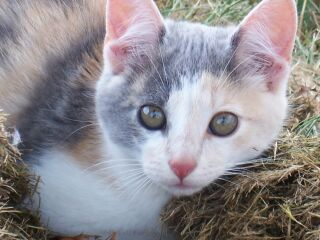

In [22]:
Image(filename=cat_img)

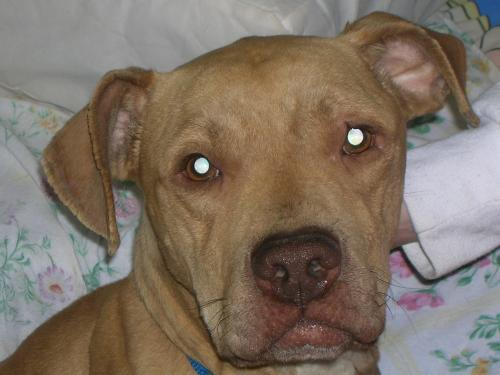

In [23]:
Image(filename=dog_img)

In [24]:
from tensorflow.keras.preprocessing import image

def predict_image(img_path):
    # Read the image and resize it
    img = image.load_img(img_path, target_size=(height, width))
    # Convert it to a Numpy array with target shape.
    x = image.img_to_array(img)
    # Reshape
    x = x.reshape((1,) + x.shape)
    x /= 255.
    result = model.predict([x])[0][0]
    if result > 0.5:
        animal = "cat"
    else:
        animal = "dog"
        result = 1 - result
    return animal,result

print(predict_image(cat_img))
print(predict_image(dog_img))

('cat', 0.9970092)
('dog', 0.9999761069502711)


## Download the model

In [31]:
model.input_shape

(None, 150, 150, 3)

## Load the model

In [32]:
from efficientnet.layers import Swish, DropConnect
from efficientnet.model import ConvKernalInitializer
from tensorflow.keras.utils import get_custom_objects

get_custom_objects().update({
    'ConvKernalInitializer': ConvKernalInitializer,
    'Swish': Swish,
    'DropConnect':DropConnect
})

In [33]:
from tensorflow.keras.models import load_model
model = load_model("./models/cats_and_dogs_small.h5")